### Historical Product Demand - Code to run forecast automatically
This notebook gives code to run the forecast automatically. <br/>

Several notes: <br/>
- The logic behind the code can be found in notebook name "Historical Product Demand (Analysis + Model)". <br/>
- There is hardcode to remove data before Sep 2011. The reason is that the provided dataset seems to have several flaws because there were no data provided for several months in 2011 (Feb, Mar, Apr, Jul, and Aug). Usually, forecast user just extract historical data from system and thus, can't have those months missed for all products. <br/>
- There is code to set current_date = 2017/01/10. Because the latest data is on 2017/01/09, I suppose that it is currently Jan, 2017 and the forecast user wants to get forecast from March onwards (as stated in the objective of the dataset.)

In [2]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import attrgetter
#pip install pmdarima
from pmdarima.arima import auto_arima
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
#pip install pystan
#conda install -c conda-forge fbprophet
from fbprophet import Prophet

In [3]:
def forecast_run(data,fcastperiods):
    "Format data"
    data['Date'] = pd.to_datetime(data['Date']) ## Format Date to datetime
    data['Order_Demand'] = data['Order_Demand'].str.replace('(','-') # Format Order_Demand to numeric
    data['Order_Demand'] = data['Order_Demand'].str.replace(')','') 
    data['Order_Demand'] = pd.to_numeric(data['Order_Demand'])
    data = data.drop(columns=['Warehouse','Product_Category']) # Drop warehouse and category columns
    data = data.sort_values('Date').reset_index().drop('index',axis=1) # Sort data by period
    
    "Remove NA"
    data = data.dropna(how='any',axis=0)
    
    "Remove returns values"
    data['Abs_Demand'] = abs(data['Order_Demand']) # Create column with absolute values of order_demand column
    data_nodup = data.drop_duplicates(subset = ['Product_Code','Date','Abs_Demand'], keep = False) # Re duplicates
    duplicates = data.iloc[~data.index.isin(data_nodup.index)] # Extract removed duplicates to df and aggregate
    duplicates = pd.pivot_table(duplicates, values='Order_Demand',index=['Product_Code','Date'],aggfunc=np.sum
                           ).reset_index()
    duplicates = duplicates.loc[duplicates['Order_Demand']>0]
    data = data.drop_duplicates(subset = ['Product_Code','Date','Abs_Demand'], keep = False) # Re neg values
    data = data.drop('Abs_Demand',axis=1)
    data = data.loc[data['Order_Demand']>0]
    data = pd.concat([data,duplicates], ignore_index = True) # Add duplicates table back to data
    
    "Aggregate data by month"
    data['Date'] = data['Date'].dt.to_period('M')
    data = data.rename(columns = {"Date": 'Period'})
    data = data.groupby(['Product_Code','Period'])['Order_Demand'].sum().reset_index().sort_values('Period'
            ).reset_index().drop('index',axis=1)
    
    "Remove data before Sep 2016 - Reason explained in description" 
    data = data.loc[data['Period'] > '2011-08']
    
    "Remove products ineligible for forecasting"
    current_date = pd.to_datetime("2017-01-10") # replace python code to get today's date
    current_date = current_date.to_period('M')
    data = data.loc[data['Period']<current_date] # remove data of current month
    
    latest_datamonth = data.groupby('Product_Code')['Period'].max().reset_index() # remove stopped products
    latest_month = data['Period'].max()-12
    stopped_month = latest_datamonth.loc[latest_datamonth['Period'] <= latest_month] # to get stopped product list
    stopped_products = data.loc[data['Product_Code'].isin(stopped_month['Product_Code'])]
    stopped_products_list = set(stopped_products['Product_Code'].tolist())
    
    latest_datamonth = latest_datamonth.loc[latest_datamonth['Period'] > latest_month] # remove stopped products     
    data = data.loc[data['Product_Code'].isin(latest_datamonth['Product_Code'])]      
    
    duration_data = data.groupby('Product_Code').agg({'Period': ['min', 'max']}).reset_index() # re new products
    duration_data['Duration'] = (duration_data[('Period', 'max')] - duration_data[('Period', 'min')]
                            ).apply(attrgetter('n')) + 1
    new_month = duration_data.loc[duration_data['Duration'] <= 24 ]
    new_products = data.loc[data['Product_Code'].isin(new_month['Product_Code'])]
    new_products_list = set(new_products['Product_Code'].tolist())
    
    duration_data = duration_data.loc[duration_data['Duration'] > 24 ]
    data = data.loc[data['Product_Code'].isin(duration_data['Product_Code'])]
    
    "Construct time series in a columnar format"
    data = pd.pivot_table(data, values = 'Order_Demand', index = 'Period', columns = 'Product_Code',
                          aggfunc=np.sum).reset_index().rename_axis("", axis="columns")
    data = data.fillna(0)
    data = data.set_index('Period')
    
    "Sample data for demonstration"
    data = data[['Product_0002','Product_0138','Product_0597','Product_0875','Product_2066',
               'Product_2091','Product_2127','Product_2165']]
    
    """Build models"""
    def train_test(data):
        myList = data.tolist() 
        i = myList.index(next(filter(lambda x: x!=0, myList)))
        data = data.iloc[i:,] 
        train = data[:int(0.7*(len(data)))]
        test = data[int(0.7*len(data)):] 
        return train, test, data

    start = data.index.tolist()[-1] + 3
    full_period = [start + x for x in range(0,fcastperiods)]
    
    "ARIMA Model"
    Arima = ['Arima']
    ArimaFcastPerf = pd.DataFrame({'Models': Arima})
    ArimaData = pd.DataFrame({'Period': full_period, 'Model': 'Arima'})

    def arimafcast(data):
        for i in data.columns:
            try:
                train, test, full = train_test(data[i])

                # Test model
                model_pred = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3,
                                        m=1, seasonal=False, trace=True, 
                                        error_action='ignore', suppress_warnings=True)
                model_pred.fit(train)
                pred = np.round(model_pred.predict(n_periods=len(test)))
                ArimaFcastPerf[i] = sqrt(mean_squared_error(test,pred))

                # Forecast model
                model_fc = auto_arima(full, start_p=0, start_q=0, max_p=3, max_q=3,
                                        m=1, seasonal=False, trace=True, 
                                        error_action='ignore', suppress_warnings=True)
                model_fc.fit(full)
                forecast = np.round(model_fc.predict(n_periods=fcastperiods+2))
                ArimaData[i] = forecast[-fcastperiods:]
            except:
                ArimaFcastPerf[i] = np.nan
                ArimaData[i] = np.nan
        return ArimaFcastPerf, ArimaData
    arimafcast(data)
    
    "SARIMA Model"
    SArima = ['SArima']
    SArimaFcastPerf = pd.DataFrame({'Models': SArima})
    SArimaData = pd.DataFrame({'Period': full_period, 'Model': 'SArima'})

    def sarimafcast(data):
        for i in data.columns:
            try:
                train, test, full = train_test(data[i])

                # Test model
                model_pred = auto_arima(train, start_p=0, start_q=0, max_p=3, max_q=3,
                                      m=12, trace=True, 
                                      error_action='ignore', suppress_warnings=True)
                model_pred.fit(train)
                pred = np.round(model_pred.predict(n_periods=len(test)))
                SArimaFcastPerf[i] = sqrt(mean_squared_error(test,pred))

                # Forecast model
                model_fc = auto_arima(full, start_p=0, start_q=0, max_p=3, max_q=3,
                                      m=12, trace=True, 
                                      error_action='ignore', suppress_warnings=True)
                model_fc.fit(full)
                forecast = np.round(model_fc.predict(n_periods=fcastperiods+2))
                SArimaData[i] = forecast[-fcastperiods:]
            except:
                SArimaFcastPerf[i] = np.nan
                SArimaData[i] = np.nan
        return SArimaFcastPerf, SArimaData
    sarimafcast(data)    
       
    "Simple Exponential Smoothing"
    SES = ['SES']
    SESFcastPerf = pd.DataFrame({'Models': SES})
    SESData = pd.DataFrame({'Period': full_period, 'Model': 'SES'})

    def sesfcast(data):
        for i in data.columns:
            try:
                train, test, full = train_test(data[i])

                # Test model
                model_pred = SimpleExpSmoothing(train).fit()
                pred = np.round(model_pred.forecast(len(test)))
                SESFcastPerf[i] = sqrt(mean_squared_error(test,pred))

                # Forecast model
                model_fc = SimpleExpSmoothing(full).fit()
                forecast = np.round(model_fc.forecast(fcastperiods+2))
                SESData[i] = forecast.tolist()[-fcastperiods:]            
            except:
                SESFcastPerf[i] = np.nan
                SESData[i] = np.nan
        return SESFcastPerf, SESData
    sesfcast(data)
    
    "Double Exponential Smoothing"
    DES = ['DES']
    DESFcastPerf = pd.DataFrame({'Models': DES})
    DESData = pd.DataFrame({'Period': full_period, 'Model': 'DES'})

    def desfcast(data):
        for i in data.columns:
            try:
                train, test, full = train_test(data[i])
                if (train.min() != 0) and (test.min() !=0):
                    # Test model
                    model_pred = Holt(train,damped=True).fit()
                    pred = np.round(model_pred.forecast(len(test)))
                    DESFcastPerf[i] = sqrt(mean_squared_error(test,pred))

                    # Forecast model
                    model_fc = Holt(full,damped=True).fit()
                    forecast = np.round(model_fc.forecast(fcastperiods+2))
                    DESData[i] = forecast.tolist()[-fcastperiods:]
                else:
                    DESFcastPerf[i] = np.nan
                    DESData[i] = np.nan  
            except:
                DESFcastPerf[i] = np.nan
                DESData[i] = np.nan
        return DESFcastPerf, DESData
    desfcast(data)
    
    "Triple Exponential Smoothing"
    TES = ['TES']
    TESFcastPerf = pd.DataFrame({'Models': TES})
    TESData = pd.DataFrame({'Period': full_period, 'Model': 'TES'})

    def tesfcast(data):
        for i in data.columns:
            try:
                train, test, full = train_test(data[i])
                if (train.min() != 0) and (test.min() != 0):
                    # Test model                
                    model_pred = ExponentialSmoothing(train, seasonal_periods=12, 
                                                     trend='add', seasonal='mul', damped=True
                                                    ).fit(optimized=True,use_boxcox=True)
                    pred = np.round(model_pred.forecast(len(test)))
                    TESFcastPerf[i] = sqrt(mean_squared_error(test,pred))

                    # Forecast model
                    model_fc = ExponentialSmoothing(full, seasonal_periods=12, 
                                                     trend='add', seasonal='mul', damped=True
                                                    ).fit(optimized=True,use_boxcox=True)
                    forecast = np.round(model_fc.forecast(fcastperiods+2))                
                    TESData[i] = forecast.tolist()[-fcastperiods:]
                else:
                    TESFcastPerf[i] = np.nan
                    TESData[i] = np.nan       
            except:
                TESFcastPerf[i] = np.nan
                TESData[i] = np.nan   
        return TESFcastPerf, TESData
    tesfcast(data)
    
    "Prophet"
    Prophetf = ['Prophet']
    ProphetfFcastPerf = pd.DataFrame({'Models': Prophetf})
    ProphetfData = pd.DataFrame({'Period': full_period, 'Model': 'Prophet'})

    def prophetfForecast(data): 
        for i in data.columns:
            try:
                myList = data[i].tolist()
                j = myList.index(next(filter(lambda x: x!=0, myList)))
                temp = data.iloc[j:,]        
                temp['ds']=temp.index.astype('datetime64[ns]')
                temp = temp.reset_index(drop=True)
                temp = temp.rename(columns = {i:'y'})
                temp = temp.loc[:,['ds','y']]

                train = temp[:int(2/3*(len(temp)))]
                test = temp[int(2/3*len(temp)):]

                # Test model
                model_pred = Prophet()
                model_pred.fit(train)
                pred = model_pred.predict(test)
                ProphetfFcastPerf[i] = sqrt(mean_squared_error(test['y'].values,pred['yhat'].values))

                # Forecast model
                model_fc = Prophet()
                model_fc.fit(temp)

                fc_ds = ProphetfData.copy().set_index('Period')
                fc_ds['ds']=fc_ds.index.astype('datetime64[ns]')
                fc_ds = fc_ds.reset_index(drop=True).drop('Model',axis=1)

                forecast = model_fc.predict(fc_ds)
                ProphetfData[i] = np.round(forecast['yhat'].values)
            except:
                ProphetfFcastPerf[i] = np.nan
                ProphetfData[i] = np.nan
        return ProphetfFcastPerf, ProphetfData    
    prophetfForecast(data)    
    
    "Compare and select the best model for each product"
    FcastPerf = pd.concat([ArimaFcastPerf,SArimaFcastPerf,SESFcastPerf,DESFcastPerf,TESFcastPerf,
                           ProphetfFcastPerf]).set_index('Models')
    Model = pd.DataFrame() # Find best model for each product
    for i in FcastPerf.columns:
        Model[i] = list([FcastPerf.loc[FcastPerf[i] == FcastPerf[i].min()].index[0]])

    model_dict = {} # Filter list of products per model
    model_list = ['Arima', 'SArima', 'SES', 'DES', 'TES', 'Prophet']
    for i in model_list:
        model_dict[i] = []

    for i in Model.columns:
        for j in model_list:
            if any(Model[i] == j):
                model_dict[j].append(i)

    AllForecast = pd.concat([ArimaData, SArimaData, SESData, DESData, TESData, ProphetfData]) # Extract forecast
    FinalForecast = pd.DataFrame({'Period': full_period})

    for i in model_list:
        for j in model_dict[i]:
            FinalForecast[j] = AllForecast.loc[AllForecast['Model'] == i][j]
    FinalForecast = FinalForecast.set_index('Period')
    
    HistoricalData = data[sorted(data)] # Combine historical and forecast data
    FinalForecast = FinalForecast[sorted(FinalForecast)]
    FinalData = pd.concat([HistoricalData,FinalForecast])
    
    FinalData['Data Type'] = np.nan # Insert Data_Type column and move it to front.
    FinalData['Data Type'].iloc[:-fcastperiods] = 'Historical Data'
    FinalData['Data Type'].iloc[-fcastperiods:] = 'Forecast'
    co_list = FinalData.columns.tolist() 
    co_list.insert(0, co_list.pop(co_list.index('Data Type'))) 
    FinalData = FinalData.reindex(columns= co_list)    
    
    return FinalData, stopped_products_list, new_products_list

In [4]:
%%capture
# Read data
data = pd.read_csv("Historical Product Demand.csv")
fcastperiods = 12 #forecast user to input this number
FinalData, stopped_products_list, new_products_list = forecast_run(data,fcastperiods)

In [5]:
FinalData

,Data Type,Product_0002,Product_0138,Product_0597,Product_0875,Product_2066,Product_2091,Product_2127,Product_2165
Period,,,,,,,,,
2011-09,Historical Data,0.0,0.0,0.0,5450.0,0.0,0.0,0.0,0.0
2011-10,Historical Data,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-11,Historical Data,0.0,2040.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-12,Historical Data,221000.0,5812.0,0.0,0.0,0.0,0.0,0.0,107.0
2012-01,Historical Data,65000.0,1590.0,0.0,0.0,0.0,0.0,0.0,115.0
...,...,...,...,...,...,...,...,...,...
2017-10,Forecast,131138.0,3939.0,2.0,261.0,90.0,98.0,132.0,91.0
2017-11,Forecast,131138.0,2116.0,2.0,261.0,214.0,98.0,132.0,91.0
2017-12,Forecast,131138.0,3541.0,2.0,261.0,110.0,98.0,132.0,91.0


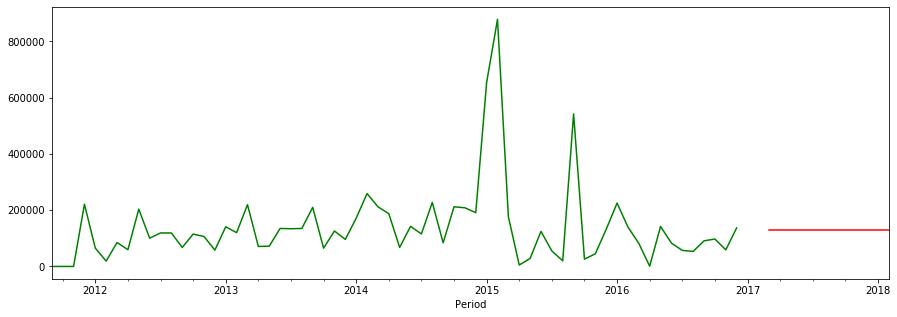

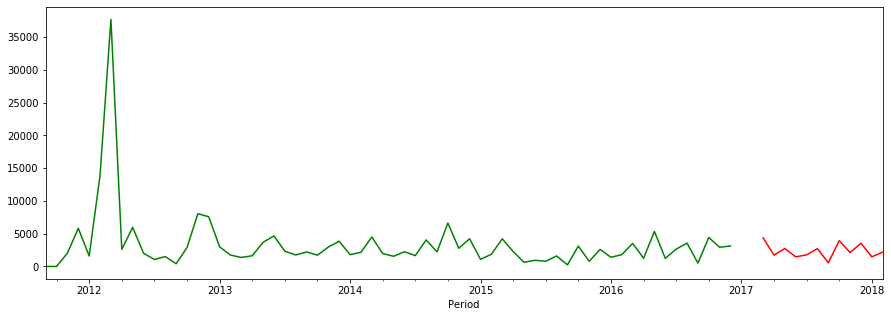

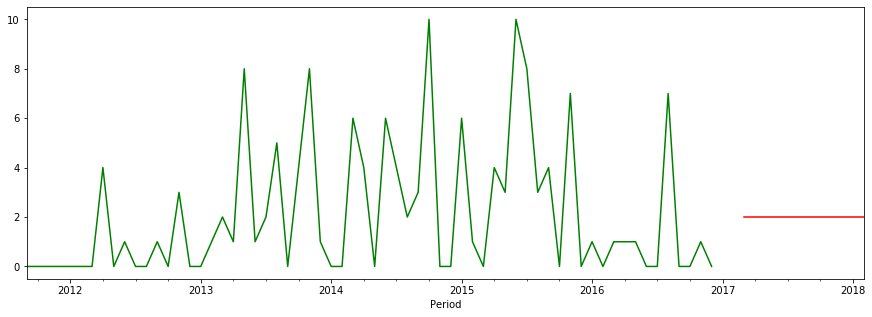

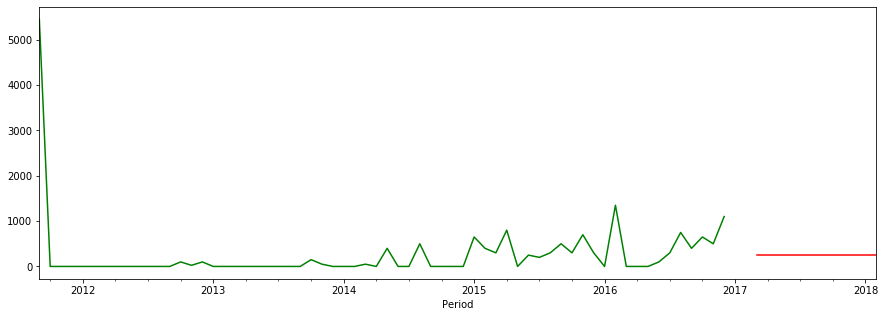

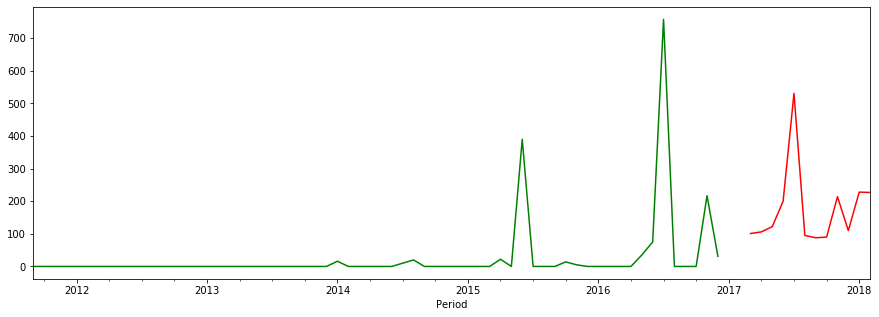

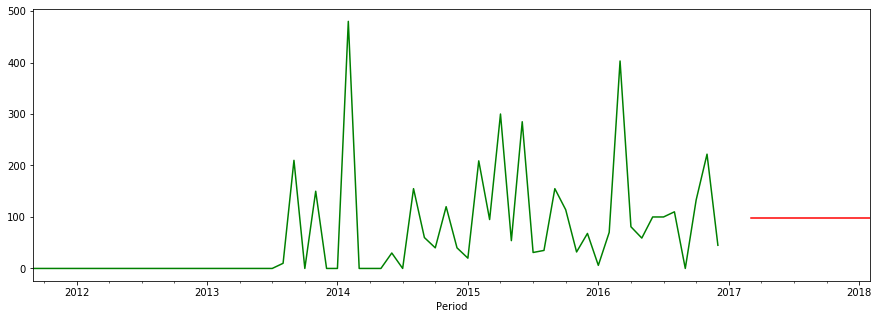

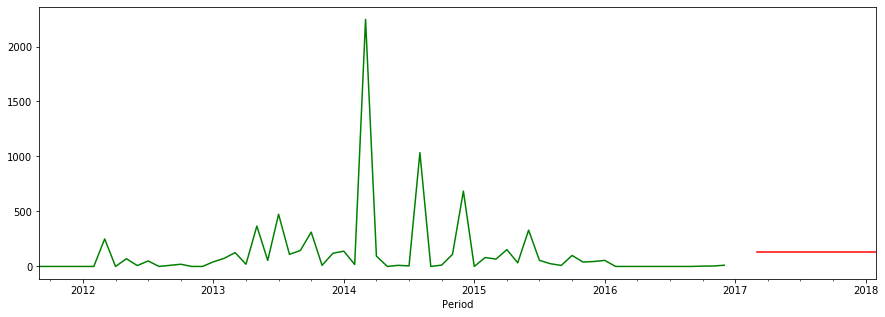

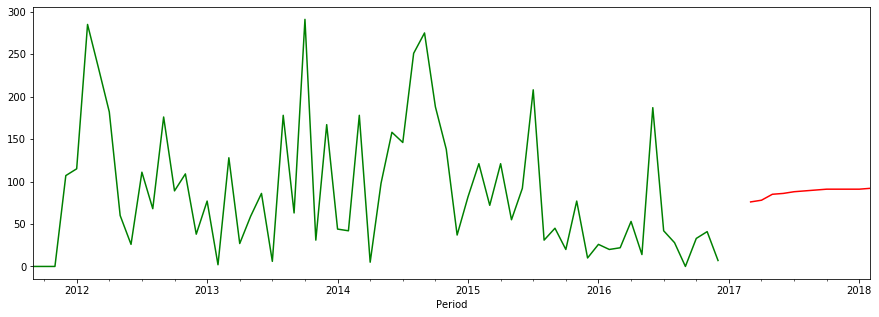

In [8]:
# Plot each product column in the final data   
for i in FinalData.columns[1:]:
    ax = FinalData[i].iloc[:-fcastperiods].plot(figsize=(15, 5), color ='green')
    FinalData[i].iloc[-fcastperiods:].plot(ax=ax, color ='red')
    fig = ax.get_figure()
    plt.show(block=False)
    plt.close(fig)

In [9]:
len(stopped_products_list)

41

In [10]:
len(new_products_list)

58